<a href="https://colab.research.google.com/github/chaitanyaa1512/Amazon_Web_Scrapping_and_Data_Analysis/blob/main/Amazon_Product_Smart_Locks_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
#importing the relevant libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time

# URL of the Amazon Smart Locks Web Page
url_template = "https://www.amazon.com/s?k=smart+lock&page={page}&crid=2A0VLCNI653XM&sprefix=smart+lock%2Caps%2C2815&ref=nb_sb_ss_ts-doa-p_2_10"

# Setting up the header for initialising the HTTP request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9"
}

# Creating an empty list to store product details
products = []

#Running a loop for scraping first 20 pages
for page in range(1, 21):
    url = url_template.format(page=page)

    # HTTP request to fetch the content of the Web Page
    response = requests.get(url, headers=headers)

    # Checking if the request was successful with no Respinse 503 error
    if response.status_code == 200:
        # Parsing the content with BeautifulSoup
        soup = BeautifulSoup(response.content, "html.parser")

        # Select the product listings
        product_selectors = soup.select(".s-main-slot .s-result-item")

        # Reiterate over the product listings to extract details
        for product in product_selectors:
            product_details = {}

            # Fetch the Brand Name
            title_element = product.find("span", class_="a-size-base-plus a-color-base a-text-normal")
            if title_element:
                title_text = title_element.text.strip()
                product_details["Brand Name"] = title_text.split(" ")[0]  # Take the first word as brand
            else:
                product_details["Brand Name"] = "Not Available"

            # Fetch the Product Price
            price_whole = product.find("span", class_="a-price-whole")
            price_fraction = product.find("span", class_="a-price-fraction")
            if price_whole and price_fraction:
                product_details["Price"] = f"${price_whole.text.strip()}{price_fraction.text.strip()}"
            else:
                product_details["Price"] = "Not Available"

            # fetch the Product Rating
            rating = product.find("span", class_="a-icon-alt")
            if rating:
                product_details["Rating"] = rating.text.strip()
            else:
                product_details["Rating"] = "Not Available"

            # Fetch the Rating Count(No. of Ratings)
            rating_count = product.find("span", class_="a-size-base")
            if rating_count:
                product_details["Rating Count"] = rating_count.text.strip()
            else:
                product_details["Rating Count"] = "Not Available"
            review_count = product.find("span", class_="a-size-base")

            # Fetch the Product (Review count--> since there is no class for review count in the HTML page, hence assuming review count to be same as rating count for Amazon)
            if review_count:
                product_details["Review Count"] = review_count.text.strip()
            else:
                product_details["Review Count"] = "Not Available"

            # Fetch the Product's ranking on the page
            product_details["Ranking"] = product.get("data-index", "N/A")

            # Fetch the Product URL
            link = product.find("a", class_="a-link-normal s-no-outline")
            if link:
                product_details["URL"] = "https://www.amazon.com" + link.get("href")
            else:
                product_details["URL"] = "Not Available"

            # Adding the product details to the list
            products.append(product_details)

        # Adding a delay of 2 secs to avoid Amazon server traffic frequently
        time.sleep(2)

    else:
        print(f"Failed to retrieve page {page}: Status code {response.status_code}")

# Converting the list of dictionaries to a DataFrame
df = pd.DataFrame(products)

# Cleaning the data by replacing blanks/missing values/NaN with Not Available
df['Brand Name'] = df['Brand Name'].replace({"": "Not Available", np.nan: "Not Available"})

# Cleaning the price values & rounding float values to int
df['Price'] = df['Price'].str.replace('$', '').str.replace(',', '').replace('Not Available', '0').replace('', '0')
df['Price'] = df['Price'].astype(float).round().astype(int)

# Function to clean and convert the Rating column to float
def convert_rating(rating):
    try:
        return float(rating.split()[0])  # Extract numeric part from the rating string
    except (ValueError, AttributeError):
        return 0.0  # Return 0.0 for non-numeric or missing values

# Conversion to the Rating column
df['Rating'] = df['Rating'].apply(convert_rating)

# Clean and convert Ranking and Rating Count columns to integers
def clean_numeric(value):
    try:
        return int(value.replace(',', '').strip())
    except (ValueError, TypeError):
        return 0  # Return 0 for non-numeric or missing values

df['Ranking'] = df['Ranking'].apply(clean_numeric)
df['Rating Count'] = df['Rating Count'].apply(clean_numeric)

# Clean and convert Review Count column to integers
df['Review Count'] = df['Review Count'].apply(clean_numeric)

# Clean URL: replace missing/blank values with "Not Available"
df['URL'] = df['URL'].replace({"": "Not Available", np.nan: "Not Available"})

# Remove duplicates
df = df.drop_duplicates()

# Save the cleaned DataFrame to a CSV file
cleaned_filename = "cleaned_smart_lock_data.csv"
df.to_csv(cleaned_filename, index=False, encoding='utf-8')

print(f"Cleaned data saved to {cleaned_filename}")


Cleaned data saved to cleaned_smart_lock_data.csv


In [59]:
#display the data dimensions
df.shape

(295, 7)

In [60]:
#load the dataset
df=pd.read_csv('/content/cleaned_smart_lock_data.csv')

In [61]:
#display the first few rows of the data
df.head()

,Brand Name,Price,Rating,Rating Count,Review Count,Ranking,URL
0,Not Available,0,4.0,0,0,0,Not Available
1,Not Available,0,0.0,0,0,1,Not Available
2,eufy,150,4.3,0,0,3,https://www.amazon.com/eufy-Security-Fingerpri...
3,eufy,80,4.3,2641,2641,4,https://www.amazon.com/eufy-Security-Deadbolt-...
4,TEEHO,33,4.5,14992,14992,5,https://www.amazon.com/Keyless-Entry-Door-Lock...


In [62]:
#display the data dimesions
df.shape

(295, 7)

In [63]:
#display the dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand Name    295 non-null    object 
 1   Price         295 non-null    int64  
 2   Rating        295 non-null    float64
 3   Rating Count  295 non-null    int64  
 4   Review Count  295 non-null    int64  
 5   Ranking       295 non-null    int64  
 6   URL           295 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 16.3+ KB


In [68]:
import sqlite3
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/cleaned_smart_lock_data_updated.csv")

# Display the first few rows of the dataset
df.head()

,Brand Name,Price,Price_INR,Rating,Rating Count,Review Count,Ranking,URL
0,Not Available,0,0,4.0,0,0,0,Not Available
1,Not Available,0,0,0.0,0,0,1,Not Available
2,eufy,150,12600,4.3,0,0,3,https://www.amazon.com/eufy-Security-Fingerpri...
3,eufy,80,6720,4.3,2641,2641,4,https://www.amazon.com/eufy-Security-Deadbolt-...
4,TEEHO,33,2772,4.5,14992,14992,5,https://www.amazon.com/Keyless-Entry-Door-Lock...


In [70]:
#display the column info
df.columns

Index(['Brand Name', 'Price', 'Price_INR', 'Rating', 'Rating Count',
       'Review Count', 'Ranking', 'URL'],
      dtype='object')

In [71]:
# Create an SQLite database in memory
conn = sqlite3.connect(':memory:')

# Load the DataFrame into the SQLite database
df.to_sql('smart_locks', conn, index=False, if_exists='replace')

# Create a cursor object
cursor = conn.cursor()

**Query 1: Calculate the Total No. of Distinct Brands**

In [85]:
#SQL query to fetch distinct brands
query_a = """SELECT COUNT(DISTINCT [Brand Name]) AS Number_of_Brands FROM smart_locks
WHERE [Brand Name] IS NOT NULL AND [Brand Name] !='Not Available';"""
#query execution step
cursor.execute(query_a)
result_a = cursor.fetchone()
#display the result
print(f"Number of Brands: {result_a[0]}")

Number of Brands: 54


######  SQL treating Wi-Fi & WiFi as separate Brand Names hence we will standardise the values

In [91]:
# SQL query to update the brand name
query = """
UPDATE smart_locks
SET [Brand Name] = 'WiFi'
WHERE [Brand Name] IN ('WiFi', 'Wi-Fi');
"""
# query execution step
cursor.execute(query)

# Commit the changes
conn.commit()

# Update doesn't return rows so just print the execution
print("Update successful.")

Update successful.


**Query 1: Re-running the query after making the necessary changes in the Brand values**

In [92]:
#SQL query to fetch distinct brands
query_a = """SELECT COUNT(DISTINCT [Brand Name]) AS Number_of_Brands FROM smart_locks
WHERE [Brand Name] IS NOT NULL AND [Brand Name] !='Not Available';"""
#query execution step
cursor.execute(query_a)
result_a = cursor.fetchone()
#display the result
print(f"Number of Brands: {result_a[0]}")

Number of Brands: 53


**Query 2: Compute the Count of SKUs per Brand**

In [73]:
#Fetch the Count of SKUs per brand
query_b = """
SELECT [Brand Name], COUNT(*) AS SKU_Count
FROM smart_locks
GROUP BY [Brand Name]
ORDER BY SKU_Count DESC;
"""
#query execution step
cursor.execute(query_b)
result_b = cursor.fetchall()
#display the result
print("Count of SKUs per Brand:")
for row in result_b:
    print(row)

Count of SKUs per Brand:
('Not Available', 54)
('Smart', 38)
('Keyless', 26)
('Veise', 25)
('Yale', 15)
('Kwikset', 14)
('Fingerprint', 11)
('WiFi', 9)
('ULTRALOQ', 8)
('TEEHO', 7)
('Keypad', 7)
('Sifely', 5)
('Lockly', 5)
('Keyless-Entry', 5)
('Door', 5)
('eufy', 4)
('Level', 4)
('SCHLAGE', 3)
('Google', 3)
('GeekTale', 3)
('Aqara', 3)
('Wyze', 2)
('SwitchBot', 2)
('Schlage', 2)
('Proscenic', 2)
('KNOBWELL', 2)
('Hornbill', 2)
('August', 2)
('YoLink', 1)
('Wi-Fi', 1)
('VEVOR', 1)
('Tuya', 1)
('TUYA', 1)
('TMEZON', 1)
('SMONET', 1)
('Revolo', 1)
('Probrico', 1)
('Philips', 1)
('ONERVA™', 1)
('MiLocks', 1)
('MINIA', 1)
('KingForce', 1)
('Honeywell', 1)
('Harfo', 1)
('HOSOM', 1)
('Geek', 1)
('GHome', 1)
('Foxgard', 1)
('FJM', 1)
('Electronic', 1)
('Commax', 1)
('Camera', 1)
('Amazon', 1)
('52HZ', 1)
('3-in-1', 1)


**Query 3: Compute the Relative Ranking of brands wrt the Ranking of their SKUs:**

In [78]:
query_c = """
SELECT [Brand Name],
      ROUND(AVG(Ranking),2) AS Relative_Ranking
FROM smart_locks
GROUP BY [Brand Name]
ORDER BY Relative_Ranking ASC;
"""
#query execution step
cursor.execute(query_c)
result_c = cursor.fetchall()

# Convert the result to a DataFrame
df = pd.DataFrame(result_c, columns=['Brand Name', 'Relative_Ranking'])

# Display only the top 5 brands
top_5_brands = df.head(5)
print("Top 5 Brands with Lowest Relative Ranking:")
print(top_5_brands)
#display the overall result
print("Relative Ranking of Brands:")
for row in result_c:
    print(row)

Top 5 Brands with Lowest Relative Ranking:
  Brand Name  Relative_Ranking
0       52HZ               3.0
1     Amazon               4.0
2       Geek               5.0
3  Proscenic               5.0
4   KNOBWELL               8.5
Relative Ranking of Brands:
('52HZ', 3.0)
('Amazon', 4.0)
('Geek', 5.0)
('Proscenic', 5.0)
('KNOBWELL', 8.5)
('Door', 9.0)
('Harfo', 9.0)
('Tuya', 11.0)
('Electronic', 12.0)
('TEEHO', 12.29)
('Commax', 13.0)
('GHome', 13.0)
('Keyless-Entry', 13.0)
('Yale', 13.93)
('Foxgard', 14.0)
('Wyze', 14.5)
('eufy', 15.5)
('August', 16.5)
('Schlage', 17.5)
('MiLocks', 18.0)
('ONERVA™', 18.0)
('SCHLAGE', 18.0)
('TMEZON', 18.0)
('VEVOR', 18.0)
('Camera', 19.0)
('SwitchBot', 19.0)
('Honeywell', 20.0)
('Philips', 20.0)
('Not Available', 20.56)
('Keyless', 22.19)
('Smart', 22.39)
('Lockly', 23.8)
('Sifely', 23.8)
('Keypad', 23.86)
('Fingerprint', 23.91)
('Revolo', 24.0)
('HOSOM', 25.0)
('Kwikset', 25.57)
('GeekTale', 25.67)
('Aqara', 26.0)
('FJM', 26.0)
('Google', 26.67)
('ULTR

**Query 4: Compute the Relative Rating of brands wrt the Rating of their SKUs:**

In [76]:
query_d = """
SELECT [Brand Name],
       ROUND(AVG(Rating),2) AS Relative_Rating
FROM smart_locks
GROUP BY [Brand Name]
ORDER BY Relative_Rating DESC;
"""
#query execution step
cursor.execute(query_d)
result_d = cursor.fetchall()

#display the result
print("Relative Rating of Brands:")
for row in result_d:
    print(row)

Relative Rating of Brands:
('Probrico', 5.0)
('KNOBWELL', 5.0)
('ONERVA™', 4.9)
('Electronic', 4.9)
('Foxgard', 4.8)
('Geek', 4.7)
('Wyze', 4.5)
('Philips', 4.5)
('WiFi', 4.46)
('Sifely', 4.44)
('Keypad', 4.44)
('Keyless-Entry', 4.44)
('Schlage', 4.4)
('Veise', 4.38)
('TEEHO', 4.36)
('Hornbill', 4.35)
('Keyless', 4.34)
('SCHLAGE', 4.33)
('eufy', 4.3)
('Wi-Fi', 4.3)
('SMONET', 4.3)
('Harfo', 4.3)
('Smart', 4.28)
('Kwikset', 4.28)
('Lockly', 4.26)
('YoLink', 4.2)
('TUYA', 4.2)
('TMEZON', 4.2)
('SwitchBot', 4.2)
('Revolo', 4.2)
('August', 4.2)
('Aqara', 4.2)
('Proscenic', 4.15)
('Door', 4.12)
('VEVOR', 4.1)
('ULTRALOQ', 4.1)
('KingForce', 4.1)
('Honeywell', 4.1)
('Google', 4.03)
('Yale', 4.01)
('MiLocks', 3.9)
('HOSOM', 3.9)
('52HZ', 3.9)
('Amazon', 3.7)
('Level', 3.65)
('Tuya', 3.5)
('MINIA', 3.5)
('3-in-1', 3.5)
('Fingerprint', 3.44)
('Camera', 3.3)
('GeekTale', 3.03)
('FJM', 2.2)
('Not Available', 1.66)
('GHome', 0.0)
('Commax', 0.0)


**Query 5: Calculate the distribution of SKUs across different Price Bands:**

In [77]:
#price Band per SKU with Common Table expressions CTEs
query_e="""WITH PriceBand_CTE AS (
    SELECT
        CASE
            WHEN Price_INR < 4999 THEN '<INR 4999'
            WHEN Price_INR BETWEEN 3000 AND 4999 THEN 'INR 3000-4999'
            WHEN Price_INR BETWEEN 5000 AND 9999 THEN 'INR 5000-9999'
            WHEN Price_INR BETWEEN 10000 AND 14999 THEN 'INR 10000-14999'
            WHEN Price_INR BETWEEN 15000 AND 19999 THEN 'INR 15000-19999'
            ELSE 'Greater than 20000'
        END AS Price_Band
    FROM smart_locks
)
SELECT
    Price_Band,
    COUNT(*) AS SKU_Count
FROM PriceBand_CTE
GROUP BY Price_Band
ORDER BY
    CASE
        WHEN Price_Band = '<INR 4999' THEN 1
        WHEN Price_Band = 'INR 3000-4999' THEN 2
        WHEN Price_Band = 'INR 5000-9999' THEN 3
        WHEN Price_Band = 'INR 10000-14999' THEN 4
        WHEN Price_Band = 'INR 15000-19999' THEN 5
        ELSE 6
    END;
  """
#query execution step
cursor.execute(query_e)
result_e = cursor.fetchall()

#display the result
print("Distribution of SKUs across Price Bands:")
for row in result_e:
    print(row)


Distribution of SKUs across Price Bands:
('<INR 4999', 85)
('INR 5000-9999', 82)
('INR 10000-14999', 68)
('INR 15000-19999', 28)
('Greater than 20000', 32)


**Visualising the Data**

##### 1. Visualise the Top 5 Brands

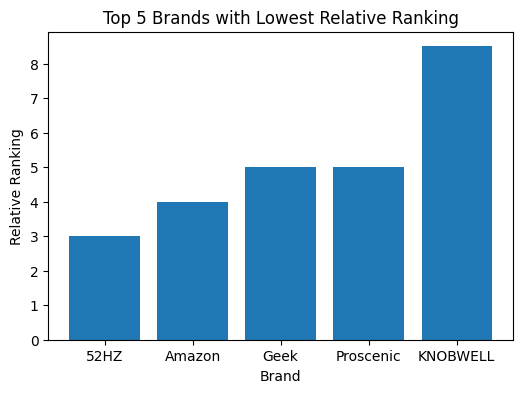

In [83]:
import matplotlib.pyplot as plt

# Set the figure size (width, height) in inches
plt.figure(figsize=(6, 4))

# Plotting the data
plt.bar(top_5_brands['Brand Name'], top_5_brands['Relative_Ranking'])

# Adding labels & Title
plt.xlabel('Brand')
plt.ylabel('Relative Ranking')
plt.title('Top 5 Brands with Lowest Relative Ranking')

# Display the plot
plt.show()

#####2. Visualise the Price Distribution of SKUs

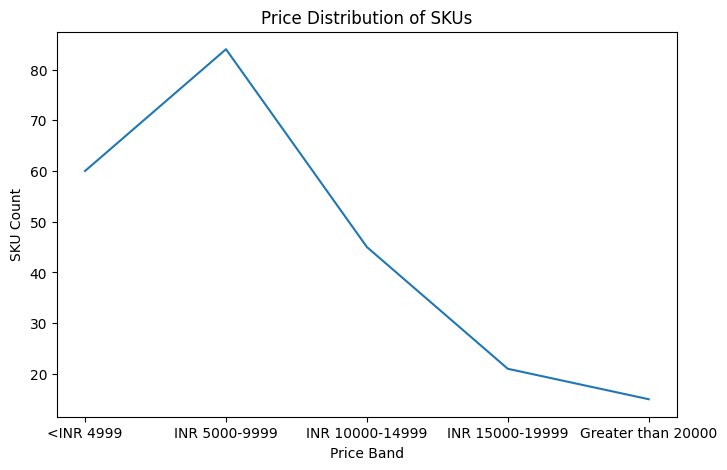

In [81]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(8, 5))

# Plotting the data
plt.plot(price_distribution['Price_Band'], price_distribution['SKU_Count'])

# Adding labels and title
plt.xlabel('Price Band')
plt.ylabel('SKU Count')
plt.title('Price Distribution of SKUs')

# Display the plot
plt.show()
